In [1]:
import tensorflow as tf
from tqdm import tqdm
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import re
import numpy as np
import os
import time
import json
from PIL import Image
import pandas as pd
import string
from tokenizers import SentencePieceBPETokenizer

from models import CNN_Encoder, RNN_Decoder, image_features_extract_model

In [10]:
data = pd.read_csv('train.csv')
data.tail(2)

,Unnamed: 0,captions,paths,sent_len,title
31998,5311,<start> how to ask for a special favor <end>,./disney_img/7642.jpg,7.0,how to ask for a special favor
31999,14755,<start> how to prepare for today’s national ad...,./disney_img/20616.jpg,7.0,how to prepare for today’s national address


In [11]:
data['sent_len'] = data['title'].apply(lambda r: len(r.split(' ')))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f017c636080>]],
      dtype=object)

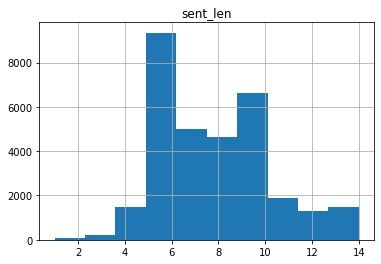

In [12]:
data.hist('sent_len')

In [5]:
VOCAB_SIZE = 3000

In [51]:
titles = data[data['sent_len']<20].title.to_list()
disney_images = data[data['sent_len']<20].paths.to_list()

with open('titles.txt', 'w') as f:
    for t in titles:
        f.write(t+'\n')

In [52]:
sbpe_tokenizer = SentencePieceBPETokenizer()
sbpe_tokenizer.train(files='titles.txt', vocab_size=VOCAB_SIZE)

In [53]:
sbpe_tokenizer.add_special_tokens(['<start>','<end>'])

2

In [54]:
sbpe_tokenizer.save('./sbpe_tokenizer','spbe_tokenizer.e')
out = sbpe_tokenizer.encode_batch(['<start> '+t+' <end>'  for t in titles])
sbpe_titles= [t.tokens for t in out]

In [55]:
max(len(t) for t in sbpe_titles)

116

In [56]:
titles_filtered = []
disney_images_filtered = []

for i,t in enumerate(sbpe_titles):
    if len(t)<=20:
        titles_filtered.append(t)
        disney_images_filtered.append(disney_images[i])
        
disney_images = disney_images_filtered
sbpe_titles = titles_filtered

print(len(titles_filtered),len(disney_images))

28667 28667


In [57]:
max(len(t) for t in sbpe_titles)

20

<start> how to get through a bail hearing with interpretive dance. <end>
['<start>', '▁how', '▁to', '▁get', '▁through', '▁a', '▁b', 'ail', '▁hear', 'ing', '▁with', '▁inter', 'p', 'ret', 'ive', '▁dance', '.', '▁', '<end>']


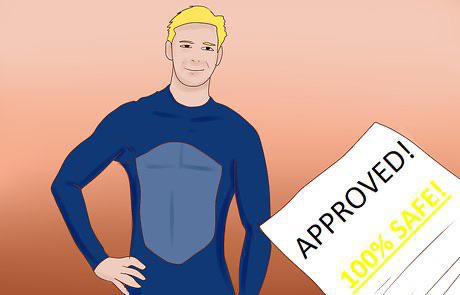

In [58]:
n = np.random.randint(len(sbpe_titles))
print(''.join(sbpe_titles[n]).replace('▁',' '))
print(sbpe_titles[n])
Image.open(disney_images[n])

In [16]:
# words = [w.lower() for s in disney_captions for w in s.split(' ')]
# print(f' vocab size: {len(set(words))}')
# print(f' captions size: {len(disney_captions) }')
# print(f' min len for captions {min(len(t.split(" ")) for t in disney_captions)}')
# print(f' max len for captions {max(len(t.split(" ")) for t in disney_captions)}')

In [59]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000  # for shuffle 
embedding_dim = 1024 # should not be equal units
embedding_words = 300
units = 512 # gru param
vocab_size = VOCAB_SIZE + 1
num_steps = len(disney_images) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
# features_shape = 2048
# attention_features_shape = 64

# features_shape_two = 768
# attention_features_two_shape = 17*17

CHECKPOINT_FOLDER = "./checkpoint_dis/augmented_w_2gru"
TOKENIZER_FOLDER = './tokenizer/'

In [18]:
encoder= CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_words, units, vocab_size)

NameError: name 'CNN_Encoder' is not defined

In [60]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):  # ZERO PADS <pad> idx - 0 
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)   

In [19]:
checkpoint_path = CHECKPOINT_FOLDER
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                          optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [62]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE,
                                                  oov_token="<unk>",
                                                  filters=None)
tokenizer.fit_on_texts(sbpe_titles)

## DISNEY CAPTIONS 
train_seqs = tokenizer.texts_to_sequences(sbpe_titles)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'


tokenizer_json = tokenizer.to_json()
with open(os.path.join(TOKENIZER_FOLDER,'tokenizer_sbpe.json'), 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

    
with open(os.path.join(TOKENIZER_FOLDER,'tokenizer_sbpe.json')) as f:
    data = json.load(f)
    tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically

max_sent_len = 20

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_sent_len)
print(f'captions vector shape {cap_vector.shape}')


img_name_train, img_name_val, cap_train, cap_val = train_test_split(disney_images,
                                                                    cap_vector,
                                                                    test_size=0.1,
                                                                    random_state=42)

#print('vals', ''.join([tokenizer.index_word[i] for i in cap_val[0]]).replace('▁',' ') , ''.join([tokenizer.index_word[i] for i in cap_val[-1]]).replace('▁',' '))

captions vector shape (28667, 20)


##### SAVE TRAIN TEST SPLIT

In [64]:
data = pd.read_csv('titles_orig_n_paths.csv')
data[data['paths'].isin(img_name_val)].to_csv('val.csv')
data[data['paths'].isin(img_name_train)].to_csv('train.csv')
print('train csv', data[data['paths'].isin(img_name_train)].shape)
print('val csv', data[data['paths'].isin(img_name_val)].shape)
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

train csv (25800, 4)
val csv (2867, 4)


(25800, 25800, 2867, 2867)

In [65]:
img_name_val[0]

'./disney_img/7711.jpg'

In [21]:
def load_image_aug(image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (299, 299))
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 10)
        if bool(np.random.randint(2)):
            img = img +  tf.keras.backend.random_normal((299,299,3),0,np.random.randint(20))
        if bool(np.random.randint(2)):
            img = tf.image.random_contrast(img, 0, 2)
        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return img, image_path

In [22]:
# Load the numpy files
def map_func(img_name, cap):
    #img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    img_tensor = load_image_aug(img_name)
    return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(map_func)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [23]:
## LOAD LAST CHECK POINT

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print(f'load from {ckpt_manager.latest_checkpoint}')
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [44]:
# preds = np.random.normal(size=(1,3001))
# loss_function(1, preds)

# real = np.array([1,1,23,11,3,21])

# mask = tf.math.logical_not(tf.math.equal(real, 0))
# loss_ = loss_object(real, preds)

# mask = tf.cast(mask, dtype=loss_.dtype)
# loss_ *= mask

# tf.reduce_mean(loss_)

In [24]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

@tf.function
def train_step(img_path, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        
        ### CNN Encoder
        batch_features_one, batch_features_two  = image_features_extract_model(img_path)
        # 768               2048
        
        # reshape ex. from  [32, 8, 8, 2048] to [32, 64, 2048]
        batch_features_one = tf.reshape(batch_features_one,
                                    (batch_features_one.shape[0], -1, batch_features_one.shape[3]))  
        
        batch_features_two = tf.reshape(batch_features_two,
                                    (batch_features_two.shape[0], -1, batch_features_two.shape[3]))
        
        features_one, features_two = encoder(batch_features_one, batch_features_two)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features_one, features_two, hidden)
            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss


In [26]:
# SAVE EACH K EPOCHS

K = 5

EPOCHS = 14

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % K == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.8092
Epoch 1 Batch 100 Loss 0.6801
Epoch 1 Batch 200 Loss 0.5656
Epoch 1 Batch 300 Loss 0.7561
Epoch 1 Batch 400 Loss 0.6094
Epoch 1 Loss 0.597818
Time taken for 1 epoch 126.98084783554077 sec

Epoch 2 Batch 0 Loss 0.7719
Epoch 2 Batch 100 Loss 0.5124
Epoch 2 Batch 200 Loss 0.6028
Epoch 2 Batch 300 Loss 0.5745
Epoch 2 Batch 400 Loss 0.4817
Epoch 2 Loss 0.535673
Time taken for 1 epoch 128.3158848285675 sec

Epoch 3 Batch 0 Loss 0.7991
Epoch 3 Batch 100 Loss 0.5084
Epoch 3 Batch 200 Loss 0.5417
Epoch 3 Batch 300 Loss 0.4506
Epoch 3 Batch 400 Loss 0.5342
Epoch 3 Loss 0.479925
Time taken for 1 epoch 129.33481192588806 sec

Epoch 4 Batch 0 Loss 0.6528
Epoch 4 Batch 100 Loss 0.4651
Epoch 4 Batch 200 Loss 0.4647
Epoch 4 Batch 300 Loss 0.4905
Epoch 4 Batch 400 Loss 0.3516
Epoch 4 Loss 0.437257
Time taken for 1 epoch 128.35897040367126 sec

Epoch 5 Batch 0 Loss 0.6516
Epoch 5 Batch 100 Loss 0.4373
Epoch 5 Batch 200 Loss 0.3992
Epoch 5 Batch 300 Loss 0.4875
Epoch 5 Batch 4